# ClimateNet AR/TC Analysis (Extreme Precip)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
# Previously: needed cftime < 1.5 or nc-time-axis won't work (https://github.com/SciTools/nc-time-axis/issues/58)
# This was resolved in nc-time-axis 1.3.0 (https://github.com/SciTools/nc-time-axis/releases/tag/v1.3.0)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors 

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38686 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/38686/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/38686/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.47:43416,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/38686/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Close cluster/client as needed
Do I need both these commands?

In [125]:
cluster.close()
#client.close()

distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/core.py", line 502, in handle_comm
    result = await result
  File "/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/scheduler.py", line 5054, in add_client
    self.remove_client(client=client)
  File "/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/scheduler.py", line 5081, in remove_client
    self.client_releases_keys(
  File "/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/scheduler.py", line 4821, in client_releases_keys
    self.transitions(recommendations)
  File "/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/scheduler.py", line 6753, in transitions
    self.send_all(client_msgs, worker_msgs)
  File "/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dist

### Set ClimateNet filepath

In [4]:
cesm_cnet_filepath = "/glade/campaign/cgd/amp/jet/ClimateNet/"

In [5]:
cesm_cnet_folders = ["output.cgnet.2000/", "output.cgnet.2001/", "output.cgnet.2002/", "output.cgnet.2003/", "output.cgnet.2004/", "output.cgnet.2005/"]
cesm_cnet_folders

['output.cgnet.2000/',
 'output.cgnet.2001/',
 'output.cgnet.2002/',
 'output.cgnet.2003/',
 'output.cgnet.2004/',
 'output.cgnet.2005/']

## CESM historical simulation, 2000-2005

In [6]:
cnet_files = "b.e13.B20TRC5CN.ne120_g16.003*.nc"

In [ ]:
# start with year 2000 only to solidfy workflow
cnet_2000 = xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[0]+cnet_files, concat_dim='time', combine="nested", chunks={'time':360}, parallel=True) # aim for chunk size < 100mb
cnet_2000

In [7]:
# read in all the masks, 2000-2005
cnet = [xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':360}, parallel=True) for i,f in enumerate(cesm_cnet_folders)]
# concat across time
cnet_concat = xr.concat(cnet,dim='time')

In [8]:
cnet_concat

<xarray.Dataset>
Dimensions:     (lat: 768, lon: 1152, time: 17520)
Coordinates:
  * time        (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
  * lon         (lon) float32 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
  * lat         (lat) float32 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
Data variables:
    output_tag  (time, lat, lon) uint8 dask.array<chunksize=(10, 768, 1152), meta=np.ndarray>
Attributes:
    history:  Tue Oct 26 15:32:57 2021: ncatted -a calendar,time,o,c,noleap b...
    NCO:      netCDF Operators version 4.7.9 (Homepage = http://nco.sf.net, C...

In [9]:
cnet_mask = cnet_concat.output_tag
cnet_mask

<xarray.DataArray 'output_tag' (time: 17520, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(17520, 768, 1152), dtype=uint8, chunksize=(10, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
  * lon      (lon) float32 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float32 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  segmentation tag

### static plot for visualization

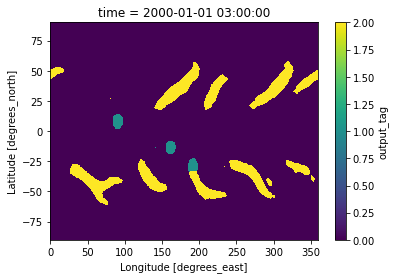

In [10]:
cnet_mask.isel(time=0).plot()

In [48]:
cmap_all = matplotlib.colors.ListedColormap(['w', 'blue', 'orange'])
bounds = [0, 0.99, 1.99, 2.99]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap_all.N)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/glade/work/kdagon/miniconda

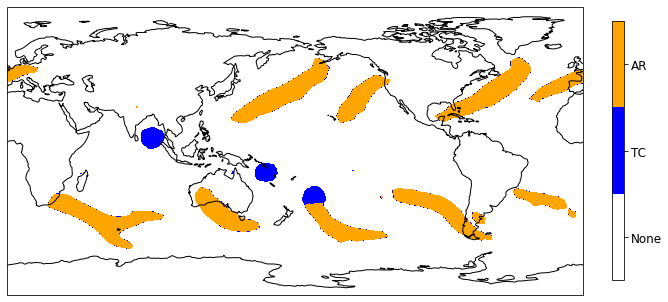

In [49]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # shift map center to highlight Pacific

lat = cnet_mask.lat
lon = cnet_mask.lon
cf = ax.contourf(lon, lat, cnet_mask[0,:,:], cmap=cmap_all, vmin=0, vmax=2.99, levels=bounds, transform=ccrs.PlateCarree())

ax.coastlines()

import matplotlib as mpl
cbar_ax = fig.add_axes([1.05, 0.2, 0.02, 0.6])
norm = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

#plt.savefig('../figures/toSCP/climatenet_updateColors_time=0.pdf', bbox_inches='tight')

### Subset AR/TC masks spatially

In [101]:
#cnet_mask_subset = cnet_mask.sel(lat=slice(25,60),lon=slice(189,250)) # Western US domain from AR analysis (e.g., Payne & Magnusdottir (2014,2015) papers, estimated)
cnet_mask_subset = cnet_mask.sel(lat=slice(32,50),lon=slice(235,246)) # Restricted western US (mostly land) domain from Collow et al. 2020
cnet_mask_subset

<xarray.DataArray 'output_tag' (time: 17520, lat: 77, lon: 36)>
dask.array<getitem, shape=(17520, 77, 36), dtype=uint8, chunksize=(10, 77, 36), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
  * lon      (lon) float32 235.0 235.3 235.6 235.9 ... 245.0 245.3 245.6 245.9
  * lat      (lat) float32 32.03 32.27 32.5 32.74 ... 49.17 49.4 49.63 49.87
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  segmentation tag

### Read in precipitation field

In [11]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/" # need to be on casper, CESM historical output

In [12]:
# h4.PRECT is 3hrly instantaneous
# h3.PRECT is 3hrly average

#PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT*FV.nc"
#PRECT_hist_file = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT.2000010100Z-2000123121Z.FV.nc" # testing year 2000 only
PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h3.PRECT*regrid*"

preprocessing function to return PRECT only\
with option to subset spatially (save memory)

In [91]:
def preprocess(ds):
    #return ds['PRECT']
    #return ds['PRECT'].sel(lat=slice(10,77),lon=slice(189,329)) # NA domain from Front analysis
    #return ds['PRECT'].sel(lat=slice(25,60),lon=slice(189,250)) # Western US domain from AR analysis (e.g., Payne & Magnusdottir (2014,2015) papers, estimated)
    return ds['PRECT'].sel(lat=slice(32,50),lon=slice(235,246)) # Restricted western US (mostly land) domain from Collow et al. 2020

read in PRECT files with preprocessing function (only with multi file?)

In [92]:
%%time
PRECT_hist = xr.open_mfdataset(cesm_hist_filepath+PRECT_hist_files, concat_dim='time', combine="nested", chunks={'time':500,'lat':100,'lon':200}, parallel=True, preprocess=preprocess)
#PRECT_hist = xr.open_dataset(cesm_hist_filepath+PRECT_hist_file, chunks={'time':500,'lat':100,'lon':200})

CPU times: user 967 ms, sys: 30.2 ms, total: 997 ms
Wall time: 10 s


In [93]:
PRECT_hist

<xarray.DataArray 'PRECT' (time: 17520, lat: 77, lon: 36)>
dask.array<concatenate, shape=(17520, 77, 36), dtype=float32, chunksize=(500, 77, 36), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 49.17 49.4 49.63 49.87
  * lon      (lon) float64 235.0 235.3 235.6 235.9 ... 245.0 245.3 245.6 245.9
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

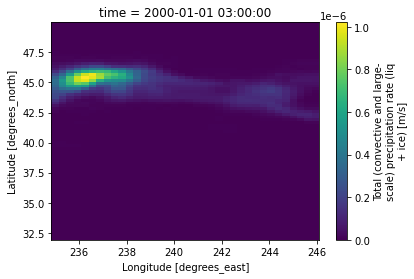

In [94]:
PRECT_hist.isel(time=0).plot()

### Calculate 90th percentile precipitation at each gridpoint

In [95]:
p90 = PRECT_hist.chunk({'time': -1}).quantile(0.9, dim='time')
p95 = PRECT_hist.chunk({'time': -1}).quantile(0.95, dim='time')

In [96]:
p90

<xarray.DataArray 'PRECT' (lat: 77, lon: 36)>
dask.array<getitem, shape=(77, 36), dtype=float64, chunksize=(77, 36), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 32.03 32.27 32.5 32.74 ... 49.17 49.4 49.63 49.87
  * lon       (lon) float64 235.0 235.3 235.6 235.9 ... 245.0 245.3 245.6 245.9
    quantile  float64 0.9

### Select gridpoints where precipitation at a given time is greater than p90 or p95

In [103]:
#PEx = PRECT_hist.where(PRECT_hist > p90)
PEx = PRECT_hist.where(PRECT_hist > p95)

In [104]:
PEx

<xarray.DataArray 'PRECT' (time: 17520, lat: 77, lon: 36)>
dask.array<where, shape=(17520, 77, 36), dtype=float32, chunksize=(500, 77, 36), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 32.03 32.27 32.5 32.74 ... 49.17 49.4 49.63 49.87
  * lon       (lon) float64 235.0 235.3 235.6 235.9 ... 245.0 245.3 245.6 245.9
  * time      (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
    quantile  float64 0.95
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

CPU times: user 985 ms, sys: 28.5 ms, total: 1.01 s
Wall time: 8.93 s


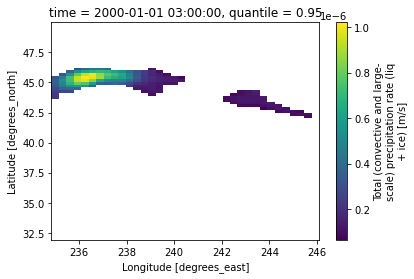

In [105]:
%%time
PEx.isel(time=0).plot();

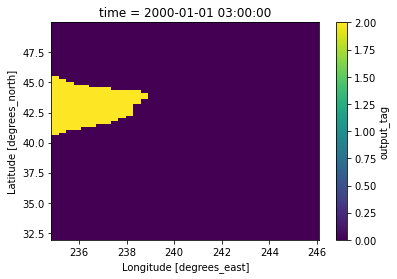

In [106]:
# ARs/TCs at the same time index
cnet_mask_subset.isel(time=0).plot();

### Find gridpoints that overlap (AR/TC & PEx)
Note for processing global files: Running out of memory for these steps (even with just year 2000). Possible solutions could include launching jupyter on compute node for >4GB memory and/or modify client memory and workflow to reduce data sizes. Or running over a specific spatial region.

In [107]:
# Define overlap separately for ARs and TCs
# NOTE: for western US, probably only going to see AR overlap
PEx_AR = PEx.where(cnet_mask_subset==2).persist()
PEx_TC = PEx.where(cnet_mask_subset==1)

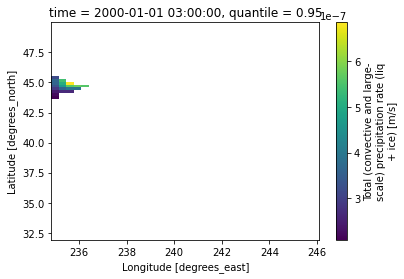

In [108]:
PEx_AR.isel(time=0).plot()

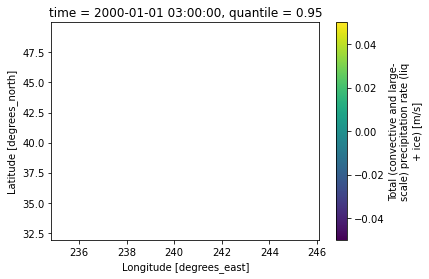

In [109]:
PEx_TC.isel(time=0).plot()

### Custom precip colormap from unidata
https://unidata.github.io/python-gallery/examples/Precipitation_Map.html \
Can skip this section if need be - just for making illustrative process plots

In [34]:
import matplotlib.colors as mcolors
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap_prec = mcolors.ListedColormap(cmap_data, 'precipitation')
norm_prec = mcolors.BoundaryNorm(clevs, cmap_prec.N)

In [40]:
t = '2000-08-21T21'
PRECT_hist.sel(time=t)[0]

<xarray.DataArray 'PRECT' (lat: 149, lon: 196)>
dask.array<getitem, shape=(149, 196), dtype=float32, chunksize=(100, 195), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 59.26 59.49 59.73 59.96
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 249.1 249.4 249.7 250.0
    time     object 2000-08-21 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

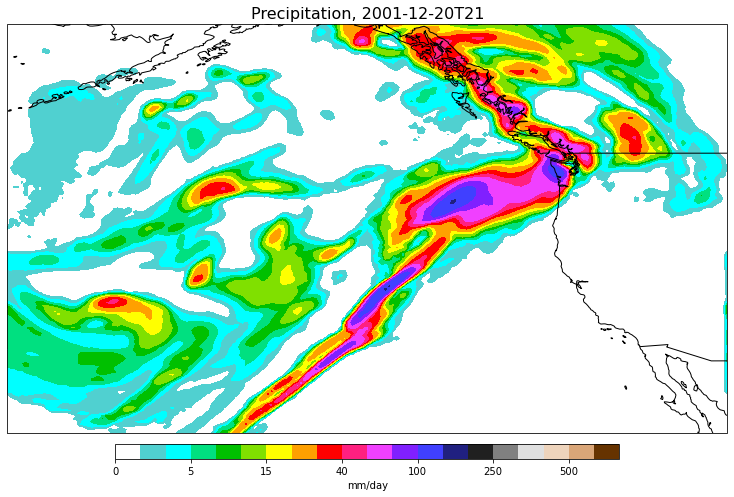

In [73]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

# PRECT
pfield = PRECT_hist.sel(time=t)[0]*1000*86400

# PEx
#pfield = PEx.sel(time=t)[0]*1000*86400

field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat

c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())
#c_prec = ax.pcolormesh(lon, lat, field, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())


# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
ax.set_title('Precipitation, '+t, fontsize=16);
#ax.set_title('90th percentile precipitation, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PRECT_CESM_2001-12-20-21.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PEx_CESM_2001-12-20-21.png', bbox_inches='tight')

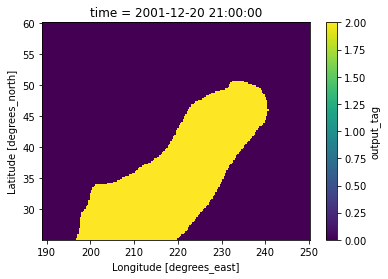

In [62]:
# fronts at the same time index
cnet_mask_subset.sel(time=t).plot();

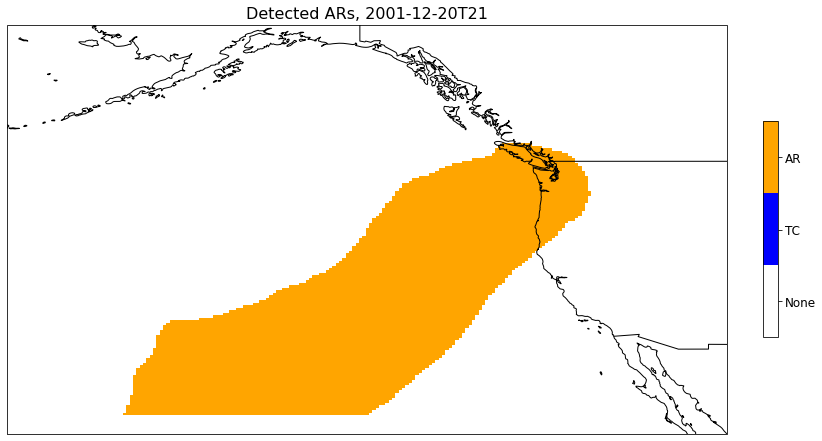

In [75]:
# clean up plot 
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

ffield = cnet_mask_subset.sel(time=t)[0]
field, lon = add_cyclic_point(ffield, coord=ffield.lon)
lat = ffield.lat
cf = ax.pcolormesh(lon, lat, field, cmap=cmap_all, vmin=0, vmax=2.99, norm=norm, transform=ccrs.PlateCarree())

# fronts colorbar
cbar_ax = fig.add_axes([1.05, 0.35, 0.02, 0.3])
norm_all_cb = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm_all_cb,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

# add title
ax.set_title('Detected ARs, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/ARs_CESM_2001-12-20-21.png', bbox_inches='tight')

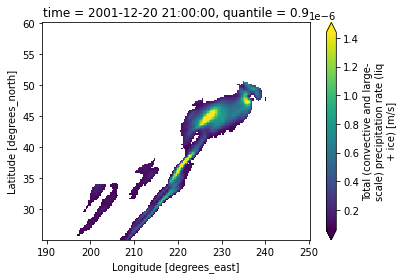

In [76]:
# PEx associated with ARs (overlapping gridpoints)
PEx_AR.sel(time='2001-12-20T21').plot(robust=True);

In [79]:
PEx_AR

<xarray.DataArray 'PRECT' (time: 17520, lat: 149, lon: 196)>
dask.array<where, shape=(17520, 149, 196), dtype=float32, chunksize=(10, 100, 195), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 25.23 25.46 25.7 25.93 ... 59.26 59.49 59.73 59.96
  * lon       (lon) float64 189.1 189.4 189.7 190.0 ... 249.1 249.4 249.7 250.0
  * time      (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
    quantile  float64 0.9
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

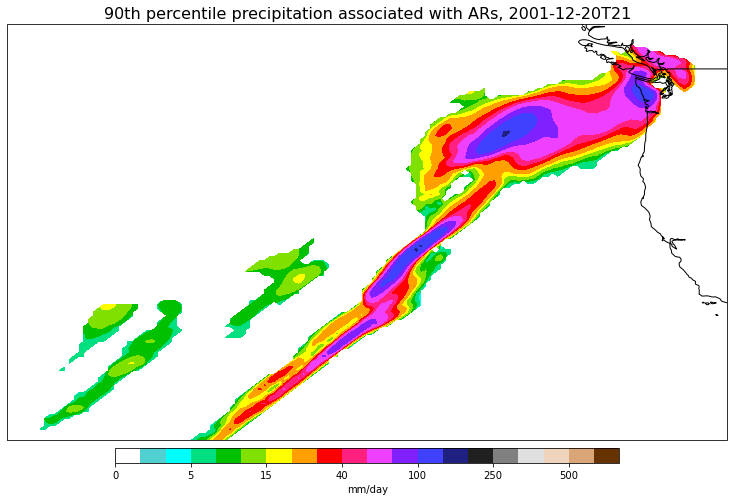

In [83]:
# clean up plot
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

# could try extending the longitude range to force the map to plot more (where there is no PEx_AR)
pfield = PEx_AR.sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())

# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
ax.set_title('90th percentile precipitation associated with ARs, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PEx_AR_CESM_2001-12-20-21.png', bbox_inches='tight')

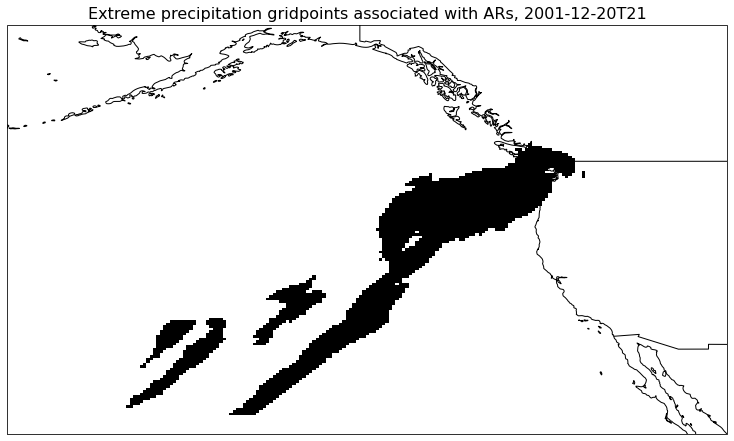

In [85]:
# gridpoints only (no precip info)

fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

pfield = (PEx_AR.sel(time=t)[0]*1000*86400).notnull()
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.pcolormesh(lon, lat, field, cmap='Greys', transform=ccrs.PlateCarree())

# add title
ax.set_title('Extreme precipitation gridpoints associated with ARs, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PEx_AR_binary_CESM_2001-12-20-21.png', bbox_inches='tight')

### Percent gridpoints that overlap, relative to PEx gridpoints (instead of total)

In [110]:
overlap = PEx_AR.notnull().sum(dim=('lat','lon'))

In [111]:
PExgridpoints = PEx.notnull().sum(dim=('lat','lon'))

In [112]:
npercentPEx = 100*(overlap/PExgridpoints)
npercentPEx

<xarray.DataArray 'PRECT' (time: 17520)>
dask.array<mul, shape=(17520,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
    quantile  float64 0.95

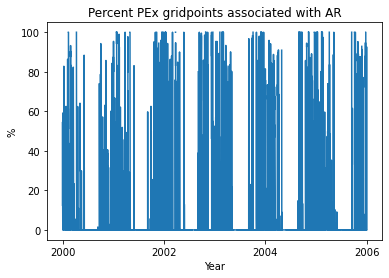

In [29]:
plt.plot(npercentPEx.time, npercentPEx)
plt.xlabel('Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with AR');
#plt.savefig('../figures/toSCP/npercentPEx-AR_2000-2005_3ha.png', bbox_inches='tight')

In [113]:
# mean by month of year
npercentPEx_monthofyear = npercentPEx.groupby("time.month").mean().persist()
# standard deviation
npercentPEx_monthofyear_std = npercentPEx.groupby("time.month").std().persist()

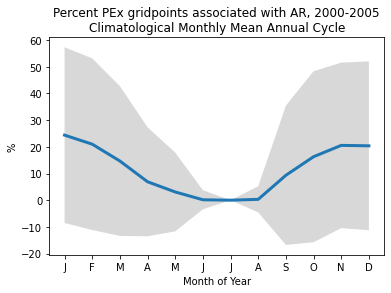

In [114]:
# with fill for standard deviation
plt.plot(npercentPEx_monthofyear.month, npercentPEx_monthofyear, linewidth=3)
plt.fill_between(npercentPEx_monthofyear.month, npercentPEx_monthofyear-npercentPEx_monthofyear_std, 
                npercentPEx_monthofyear+npercentPEx_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with AR, 2000-2005\nClimatological Monthly Mean Annual Cycle');
#plt.savefig('../figures/toSCP/npercentPEx-AR_monthofyear_withstdev_2000-2005_3ha.png', bbox_inches='tight')

In [57]:
# mean by time of day
npercentPEx_timeofday = npercentPEx.groupby("time.hour").mean().persist()
# standard deviation
npercentPEx_timeofday_std = npercentPEx.groupby("time.hour").std().persist()

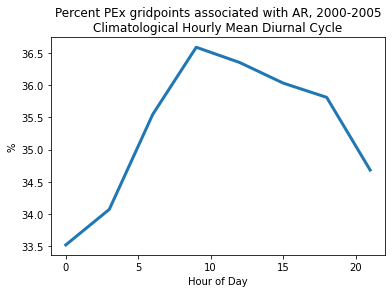

In [76]:
plt.plot(npercentPEx_timeofday.hour, npercentPEx_timeofday, linewidth=3)
#plt.fill_between(npercentPEx_timeofday.hour, npercentPEx_timeofday-npercentPEx_timeofday_std, 
#                npercentPEx_timeofday+npercentPEx_timeofday_std, alpha=0.3, facecolor='grey')
plt.xlabel('Hour of Day')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with AR, 2000-2005\nClimatological Hourly Mean Diurnal Cycle');
#plt.savefig('../figures/toSCP/npercentPEx-AR_timeofday_withstdev_2000-2005_3ha.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx-AR_timeofday_2000-2005_3ha.png', bbox_inches='tight')

### Percent gridpoints that overlap, looking over time instead of space

In [115]:
# here need to calculate p90/p95 as a timeseries instead of a spatial map. 90/95th percentile looking over space at each time point
p90_time = PRECT_hist.chunk({'lat': -1, 'lon': -1}).quantile(0.9, dim=('lat','lon'))
p95_time = PRECT_hist.chunk({'lat': -1, 'lon': -1}).quantile(0.95, dim=('lat','lon'))

In [116]:
#PEx_time = PRECT_hist.where(PRECT_hist > p90_time)
PEx_time = PRECT_hist.where(PRECT_hist > p95_time)

In [117]:
PExgridpoints_time = PEx_time.notnull().sum(dim='time')

In [118]:
# redo PEx_AR with PEx_time
PEx_AR_time = PEx_time.where(cnet_mask_subset==2)

In [119]:
overlap_time = PEx_AR_time.notnull().sum(dim='time')

In [120]:
npercentPEx_time = 100*(overlap_time/PExgridpoints_time).persist()

In [121]:
# needed to determine number of values in discrete colormap
npercentPEx_time.max().values

array(46.95652174)

CPU times: user 214 ms, sys: 3.88 ms, total: 218 ms
Wall time: 239 ms


/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


Text(0.5, 1.0, 'Percent PEx gridpoints associated with AR, 2000-2005')

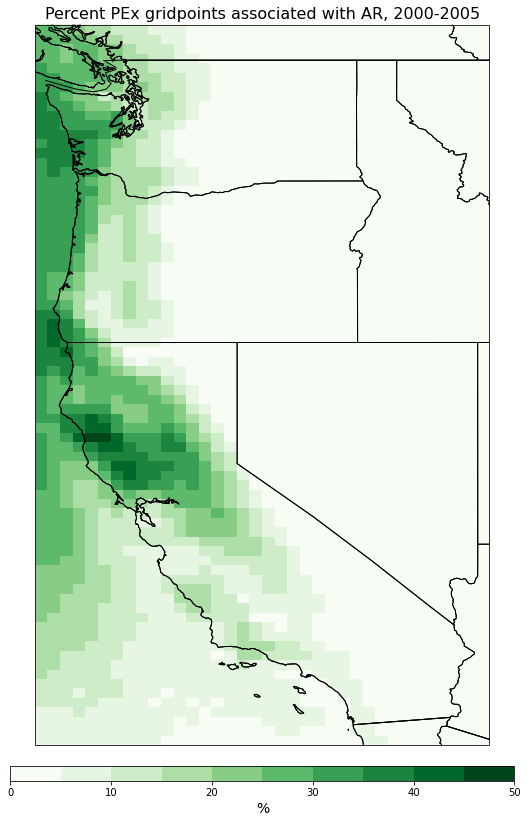

In [122]:
%%time
#fig = plt.figure(figsize=(10,10)) # Payne region
fig = plt.figure(figsize=(7,10)) # Collow region

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

# discrete colormap
#cmap=plt.cm.get_cmap('Greens', 14) # Payne region, p90
cmap=plt.cm.get_cmap('Greens', 10) # Collow region, p95

field, lon = add_cyclic_point(npercentPEx_time, coord=npercentPEx_time.lon)
lat = npercentPEx_time.lat
#cf = ax.contourf(lon, lat, field, cmap='Greens', transform=ccrs.PlateCarree())
#cf = ax.pcolor(lon, lat, field, vmin=0, vmax=70, cmap=cmap, transform=ccrs.PlateCarree()) # Payne region, p90
cf = ax.pcolor(lon, lat, field, vmin=0, vmax=50, cmap=cmap, transform=ccrs.PlateCarree()) # Collow region, p95

# add colorbar
#cb_ax = fig.add_axes([0, 0.18, 1, 0.02]) # Payne region
cb_ax = fig.add_axes([0, -0.05, 1, 0.02]) # Collow region
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('Percent PEx gridpoints associated with AR, 2000-2005', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentPEx-AR_time_2000-2005_3ha.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95th-AR_time_2000-2005_3ha_Collow.png', bbox_inches='tight')

### Seasonal spatial plots

In [123]:
# calculate number of PEx gridpoints in each month/season
PExgridpoints_time_byseason = PEx_time.notnull().groupby("time.season").sum(dim='time') # by season (4; DJF, JJA, MAM, SON)
overlap_time_byseason = PEx_AR_time.notnull().groupby("time.season").sum(dim='time')
npercentPEx_time_byseason = 100*(overlap_time_byseason/PExgridpoints_time_byseason).persist()

In [124]:
# check max for colorbar
npercentPEx_time_byseason.max().values

array(65.15151515)

CPU times: user 786 ms, sys: 6.82 ms, total: 793 ms
Wall time: 871 ms


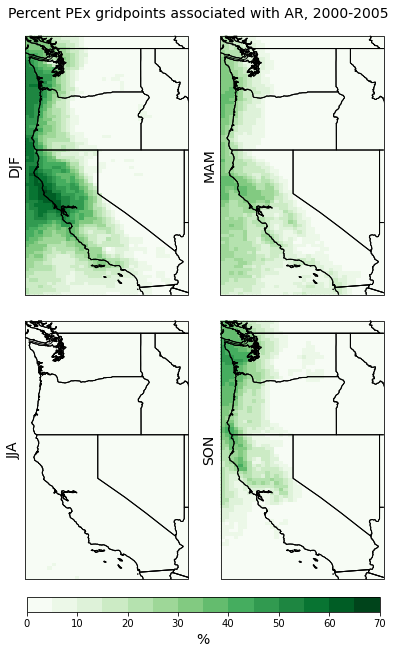

In [104]:
%%time
fig, axs = plt.subplots(2, 2, figsize=(7,10), subplot_kw={'projection': ccrs.PlateCarree()})

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 14)
#cmap=plt.cm.get_cmap('viridis', 14) # trying to replicate Collow Fig 1c colorbar

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentPEx_time_byseason.sel(season=season), coord=npercentPEx_time_byseason.lon)
    lat = npercentPEx_time_byseason.lat
    cf = axs[i].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=70, transform=ccrs.PlateCarree())
    axs[i].coastlines()
    axs[i].add_feature(cfeature.BORDERS)
    axs[i].add_feature(cfeature.STATES)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('Percent PEx gridpoints associated with AR, 2000-2005', fontsize=14, y=0.92)

plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx95th-AR_time_2000-2005_3ha_Collow_byseason.png', bbox_inches='tight')